In [1]:
# import packages
import gc
import glob
import cmcrameri.cm as ccm
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from params import savepath, homedir, allnames, datadir

plt.style.use('science.mplstyle')

states = gpd.read_file('../data/ne_110m_admin_1_states_provinces.shp')

In [2]:
domains = ['d01', 'd02', 'd03', 'd04']
coordsdict = {}
for domain in domains:
    coordsdict[domain] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_{domain}')

In [4]:
params = {'vars': ['prec','t2','snow'],
          'states' : ['CA', 'WY'],
          'res': ['45','9','3']}
res_domain = {'3': ['d03','d04'],
               '9' :['d02'],
               '45':['d01']}
domain_state = {'d01':['CA','WY'],
                'd02':['CA','WY'],
                'd03':['CA'],
                'd04':['WY'],}
boundaries = {'d01':{'CA': [43,60,35,68],
                     'WY': [68,81,43,63]},
              'd02':{'CA': [44,125,87,251],
                     'WY': [165,230,130,227]},
              'd03':{'CA': [0,-1,0,-1]},
              'd04':{'WY': [0,-1,0,-1]}}
state_res_domain = {'CA': {'45':'d01',
                            '9': 'd02',
                            '3':'d03'},
                     'WY': {'45':'d01',
                            '9': 'd02',
                            '3':'d04'},}

gcms_dict = {'d01': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd02': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd03': ['ec-earth3-veg'],
             'd04': ['ec-earth3-veg'],}
bc = 'BC'

In [5]:
def sort_files_by_time(domain, var):
    files = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_*_{domain}_{bc}.nc')
    for fn in files:
        tmp=  xr.open_dataset(fn)
        tmp = tmp.sortby('time')
        fn2 = fn.split('_BC')[0] + '_BCsorted_' + fn.split('_BC')[1] 
        tmp.to_netcdf(fn2)
    return


In [10]:
files = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_*_{domain}_BCsorted_.nc')
print(len(files))
test = xr.open_mfdataset(files)# , combine = 'nested', concat_dim = 'gcm').mean(dim = 'gcm')


9


In [ ]:
for domain in domains:
    for var in ['snow','t2']:
        sort_files_by_time(domain, var)

In [ ]:
var = 'prec'
domain = 'd02'
sort_files_by_time(domain, var)
domain = 'd03'
sort_files_by_time(domain, var)
domain = 'd04'
sort_files_by_time(domain, var)

In [15]:
%%time

## make the dictionary: 
alldata = {}
for var in params['vars']:
    alldata[var] = {}
    for state in params['states']:
        alldata[var][state] = {}
        for res in params['res']:
            alldata[var][state][res] = {}

## fill raw data
for var in params['vars']: 
    for state in params['states']:
        for res in params['res']:
            domain = state_res_domain[state][res]
            files = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_*_{domain}_BCsorted_.nc')
            print(len(files))
            alldata[var][state][res]['raw'] = xr.open_mfdataset(files) #, combine='nested',concat_dim = 'gcm')# .mean(dim = 'gcm')
            if var == 'snow':
                alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').max()
            elif var == 't2':
                tmp = alldata[var][state][res]['raw'] - 273 ##  .resample(time = '1AS')
                mask = tmp > 0
                alldata[var][state][res]['annual_max'] = tmp.where(mask).resample(time = '1AS').sum()
            else: 
                alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').sum()


            left, right, bottom, top = boundaries[domain][state]
            alldata[var][state][res]['annual_max_state'] =  alldata[var][state][res]['annual_max'].sel(lat2d = slice(bottom, top),
                                                                   lon2d = slice(left, right))

            alldata_to_save = {}

for var in params['vars']: 
    alldata_to_save[var] = {}
    for state in params['states']:
        alldata_to_save[var][state] = {}
        for res in params['res']:
            alldata_to_save[var][state][res] = {}
            alldata_to_save[var][state][res]['annual_max_clipped'] = alldata[var][state][res]['annual_max_state']
            
np.save('/glade/campaign/uwyo/wyom0112/berkeley/annual_max_clipped.npy',alldata_to_save)

9
9
1
9
9
1
9
9
1
9
9
1
9
9
1
9
9
1
CPU times: user 6.91 s, sys: 453 ms, total: 7.37 s
Wall time: 12.8 s


In [ ]:
%%time

## make the dictionary: 
alldata = {}
for var in params['vars']: 
    alldata[var] = {}
    for state in params['states']:
        alldata[var][state] = {}
        for res in params['res']:
            alldata[var][state][res] = {}

## fill raw data
for var in params['vars']: 
    for state in params['states']:
        for res in params['res']:
            for gcm in gcms[states_res_domain[state[res]]]:
                domain = state_res_domain[state][res]
                alldata[var][state][res]['raw'] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_{gcm}_{domain}_{bc}.nc')
                if var == 'snow':
                    alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').max()
                elif var == 't2':
                    tmp = alldata[var][state][res]['raw'] - 273 ##  .resample(time = '1AS')
                    mask = tmp > 0
                    alldata[var][state][res]['annual_max'] = tmp.where(mask).resample(time = '1AS').sum()
                else: 
                    alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').sum()


                left, right, bottom, top = boundaries[domain][state]
                alldata[var][state][res]['annual_max_state'] =  alldata[var][state][res]['annual_max'].sel(lat2d = slice(bottom, top),
                                                                       lon2d = slice(left, right))
                
                alldata_to_save = {}
                
for var in params['vars']: 
    alldata_to_save[var] = {}
    for state in params['states']:
        alldata_to_save[var][state] = {}
        for res in params['res']:
            alldata_to_save[var][state][res] = {}
            alldata_to_save[var][state][res]['annual_max_clipped'] = alldata[var][state][res]['annual_max_state']
np.save('/glade/campaign/uwyo/wyom0112/berkeley/annual_max_clipped.npy',alldata_to_save)

In [ ]:
%%time

## make the dictionary: 
alldata = {}
for var in params['vars']: 
    alldata[var] = {}
    for state in params['states']:
        alldata[var][state] = {}
        for res in params['res']:
            alldata[var][state][res] = {}

## fill raw data
for var in params['vars']: 
    for state in params['states']:
        for res in params['res']:
            domain = state_res_domain[state][res]
            alldata[var][state][res]['raw'] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_{gcm}_{domain}_{bc}.nc')
            if var == 'snow':
                alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').max()
            elif var == 't2':
                tmp = alldata[var][state][res]['raw'] - 273 ##  .resample(time = '1AS')
                mask = tmp > 0
                alldata[var][state][res]['annual_max'] = tmp.where(mask).resample(time = '1AS').sum()
            else: 
                alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').sum()
                

            left, right, bottom, top = boundaries[domain][state]
            alldata[var][state][res]['annual_max_state'] =  alldata[var][state][res]['annual_max'].sel(lat2d = slice(bottom, top),
                                                                   lon2d = slice(left, right))

In [4]:
%%time

## make the dictionary: 
alldata = {}
for var in params['vars']: 
    alldata[var] = {}
    for state in params['states']:
        alldata[var][state] = {}
        for res in params['res']:
            alldata[var][state][res] = {}

## fill raw data
for var in params['vars']: 
    for state in params['states']:
        for res in params['res']:
            domain = state_res_domain[state][res]
            alldata[var][state][res]['raw'] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_{gcm}_{domain}_{bc}.nc')
            if var == 'snow':
                alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').max()
            elif var == 't2':
                tmp = alldata[var][state][res]['raw'] - 273 ##  .resample(time = '1AS')
                mask = tmp > 0
                alldata[var][state][res]['annual_max'] = tmp.where(mask).resample(time = '1AS').sum()
            else: 
                alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').sum()
                

            left, right, bottom, top = boundaries[domain][state]
            alldata[var][state][res]['annual_max_state'] =  alldata[var][state][res]['annual_max'].sel(lat2d = slice(bottom, top),
                                                                   lon2d = slice(left, right))

CPU times: user 2min 44s, sys: 10min 58s, total: 13min 42s
Wall time: 40min 27s


In [86]:
%%time
## partitioning:
partition = {}
for state in params['states']:
    partition[state] = {}
    for res in params['res']:
        domain = state_res_domain[state][res]
        temp = alldata['t2'][state][res]['raw'] 
        prec = alldata['prec'][state][res]['raw']
        mask = temp['t2'] > 273.15
        rainfall = prec.where(mask)
        snowfall = prec.where(~mask)
        partition[state][res] = {}
        partition[state][res]['snowfall'] = snowfall
        partition[state][res]['rainfall'] = rainfall
        

CPU times: user 1min 6s, sys: 5min 59s, total: 7min 5s
Wall time: 26min 14s


In [96]:
partition_annual = {}
for state in params['states']:
    partition_annual[state] = {}
    for res in params['res']:
        partition_annual[state][res] = {}
        partition_annual[state][res]['snowfall'] = partition[state][res]['snowfall'].resample(time = '1AS').sum()
        partition_annual[state][res]['rainfall'] = partition[state][res]['rainfall'].resample(time = '1AS').sum()

In [97]:
np.save('/glade/campaign/uwyo/wyom0112/berkeley/partition_annual.npy',partition_annual)

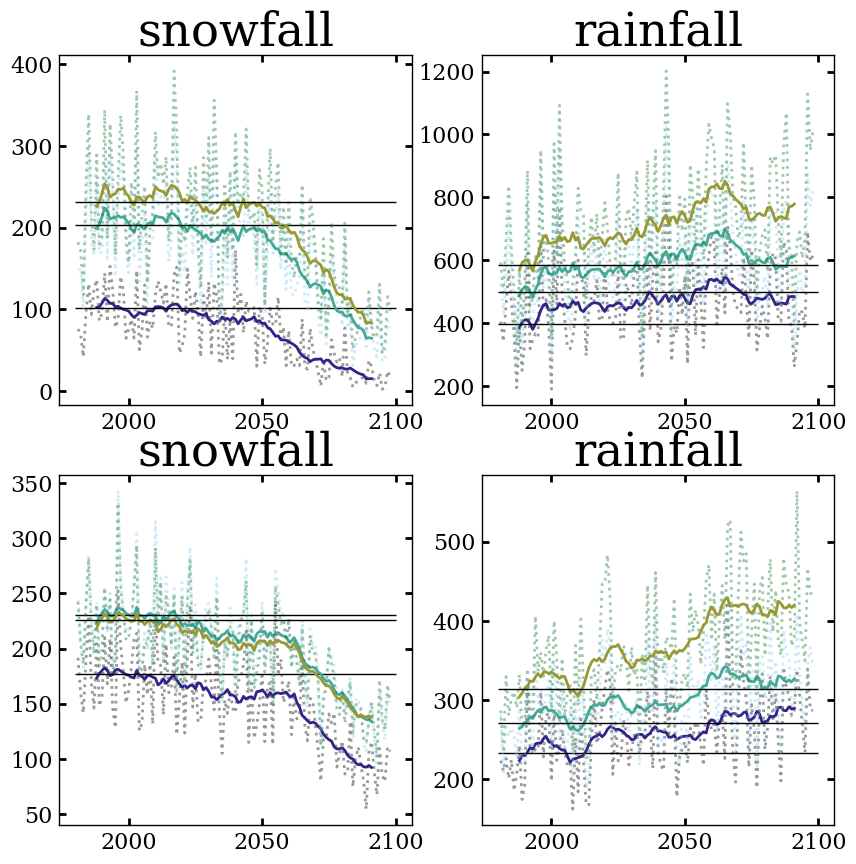

In [108]:
ws = 15
var = 'prec'
fig,axs = plt.subplots(2,2, figsize = (10,10))
for i,state in enumerate(params['states']):
    for res in params['res']:
        for j,ptype in enumerate(['snowfall','rainfall']):
            ax = axs[i,j]
            domain = state_res_domain[state][res]
            mask = snowmasks[state][res]
            left, right, bottom, top = boundaries[domain][state]
            tmp = partition_annual[state][res][ptype].sel(lat2d = slice(bottom, top),
                                                                       lon2d = slice(left, right))['prec']
            data = np.nanmean(tmp.where(mask), axis = (1,2))[1:-2]
            years = alldata[var][state][res]['annual_max_state'].time.dt.year[1:-2]
            ax.plot(years, data, linestyle = ':', alpha = 0.4)
            rolling_yearmean = pd.DataFrame(years).rolling(window = ws).mean()
            rolling_mean = pd.DataFrame(data).rolling(window=ws).mean()
            ax.plot(rolling_yearmean,rolling_mean, label = f'{res}-km')
            ax.hlines(np.nanmean(data[0:20]), 1980, 2100, linewidth = 1)
            ax.set_title(ptype)
    #ax.set_ylabel('snowfall [mm]')
# axs[0].legend(loc = 'upper left')
plt.show()

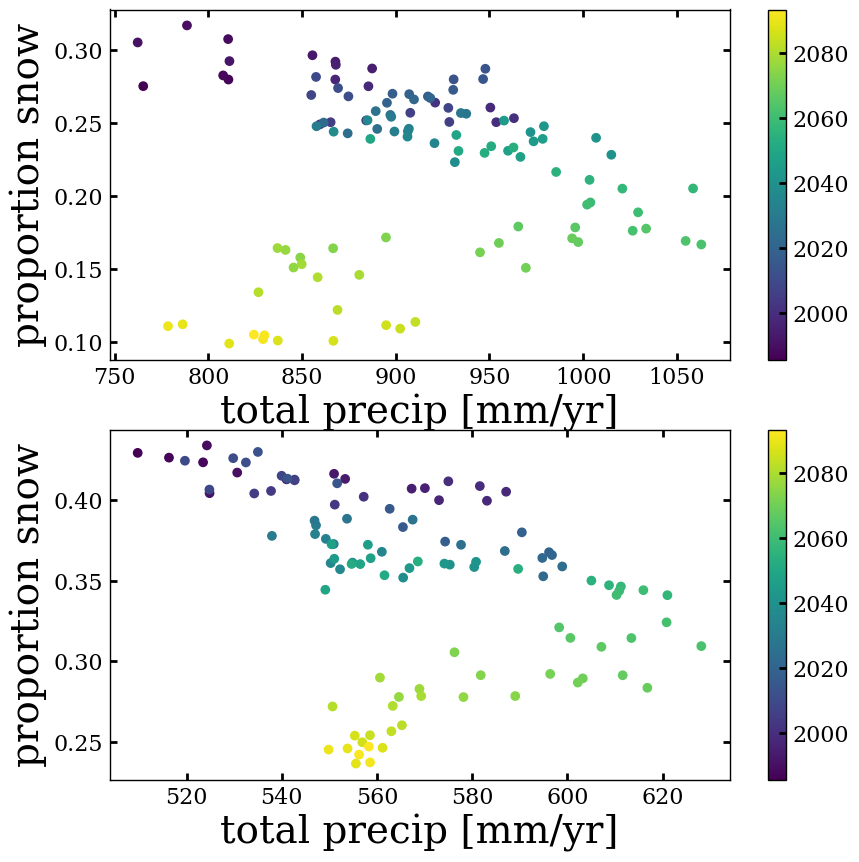

In [137]:
var = 'prec'
res = '3'
ws = 10
fig,axs = plt.subplots(2,1, figsize = (10,10))
for i,state in enumerate(params['states']):
    ax = axs[i]
    domain = state_res_domain[state][res]
    mask = snowmasks[state][res]
    left, right, bottom, top = boundaries[domain][state]
    tmpsnow = partition_annual[state][res]['snowfall'].sel(lat2d = slice(bottom, top),
                                                               lon2d = slice(left, right))['prec']
    tmprain = partition_annual[state][res]['rainfall'].sel(lat2d = slice(bottom, top),
                                                           lon2d = slice(left, right))['prec']
    snowdata = np.nanmean(tmpsnow.where(mask), axis = (1,2))[1:-2]
    raindata = np.nanmean(tmprain.where(mask), axis = (1,2))[1:-2]
    years = alldata[var][state][res]['annual_max_state'].time.dt.year[1:-2]
    rollyears = pd.DataFrame(years).rolling(window = ws).mean()[0].values
    rollsnow = pd.DataFrame(snowdata).rolling(window = ws).mean()[0].values
    rollrain = pd.DataFrame(raindata).rolling(window = ws).mean()[0].values
    #ax.stackplot(years, snowdata,raindata)
    # ax.plot(years, rollsnow / (rollsnow + rollrain))
    #ax.plot(years, rollrain)
    #ax.twinx().plot(years, rollsnow + rollrain)
    cb = ax.scatter(rollsnow + rollrain, rollsnow / (rollsnow + rollrain), c = rollyears)
    plt.colorbar(cb)
    ax.set_xlabel ('total precip [mm/yr]')
    ax.set_ylabel('proportion snow')
    # ax.stackplot(rollyears, rollsnow, rollrain)
plt.show()

/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


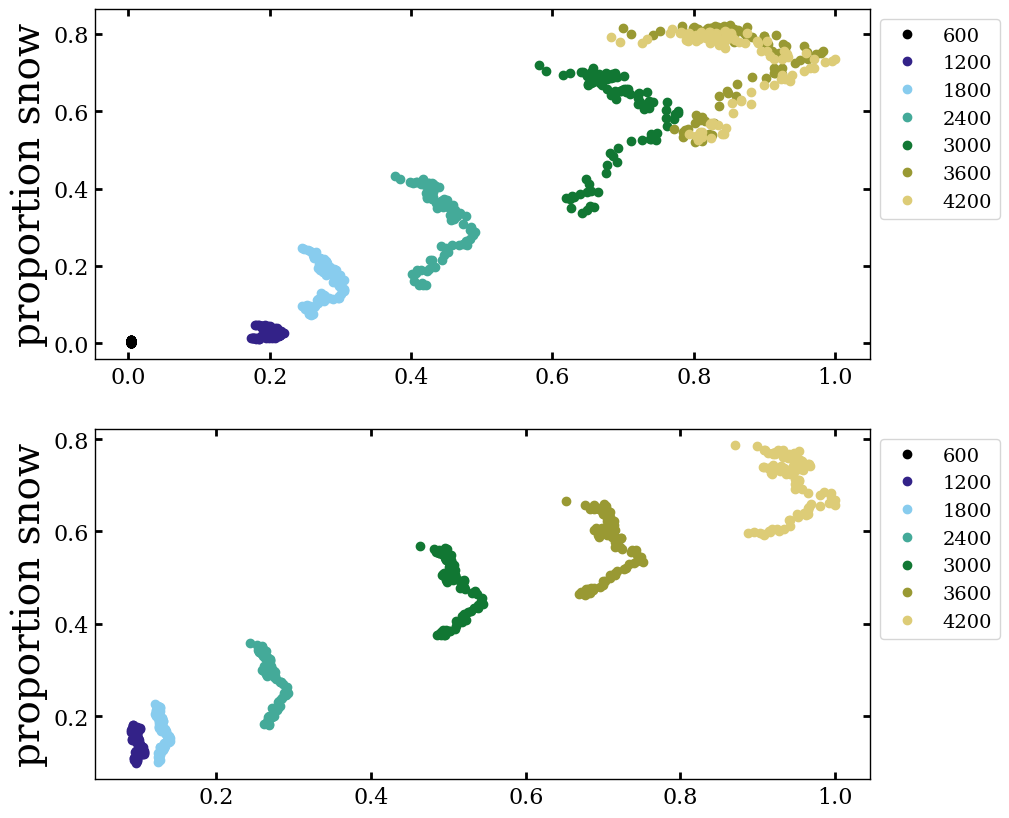

In [208]:
res = '3'
ws = 20
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

elevation_bands = np.arange(0, 4000 + 201, 600)
fig,axs = plt.subplots(2,1, figsize = (10,10))
years = range(1981,2100)
rollyears = pd.DataFrame(years).rolling(window = ws).mean()[0].values
for i,state in enumerate(params['states']):
    ax = axs[i]
    domain = state_res_domain[state][res]
    mask = snowmasks[state][res]
    left, right, bottom, top = boundaries[domain][state]
    elev = coords_clipped[state][res]['HGT'][0]
    tmpsnow = partition_annual[state][res]['snowfall'].sel(lat2d = slice(bottom, top),
                                                               lon2d = slice(left, right))['prec']
    tmprain = partition_annual[state][res]['rainfall'].sel(lat2d = slice(bottom, top),
                                                           lon2d = slice(left, right))['prec']

        # Create a mask for each elevation band
    masks = []
    for k in range(len(elevation_bands) - 1):
        emask = xr.where((elev >= elevation_bands[k]) & (elev < elevation_bands[k + 1]), 1, 0)
        masks.append(emask)

    # Combine masks into a single xarray DataArray
    mask_combined = xr.concat(masks, dim="elevation_band")
    mask_combined = mask_combined.rename({'south_north':'lat2d', 'west_east':'lon2d'})

    # Calculate the mean for each elevation band over time
    ts_snow = (tmpsnow.where(mask) * mask_combined).sum(dim=("lat2d", "lon2d")) / mask_combined.sum(dim=("lat2d", "lon2d"))
    ts_rain = (tmprain.where(mask) * mask_combined).sum(dim=("lat2d", "lon2d")) / mask_combined.sum(dim=("lat2d", "lon2d"))
    
    ts_snow = pd.DataFrame(ts_snow.values)
    ts_rain = pd.DataFrame(ts_rain.values)
    
    rolling_snow = ts_snow.rolling(window = ws).mean()
    rolling_rain = ts_rain.rolling(window = ws).mean()
    rolling_total = rolling_snow + rolling_rain
    prop_data = rolling_snow/rolling_total
    prop_scaled = pd.DataFrame(scaler.fit_transform(prop_data))
    axs[i].plot(rolling_total / np.nanmax(rolling_total), prop_data, 'o', label = elevation_bands[1:])
    # axs[i].plot(range(1980, 2101), prop_scaled ,label=elevation_bands[1:])
    axs[i].legend(frameon = True, bbox_to_anchor = [1,1,0,0])
    axs[i].set_ylabel('proportion snow')
plt.show()

In [194]:
scaled_data = pd.DataFrame(scaler.fit_transform(rolling_snow))

/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


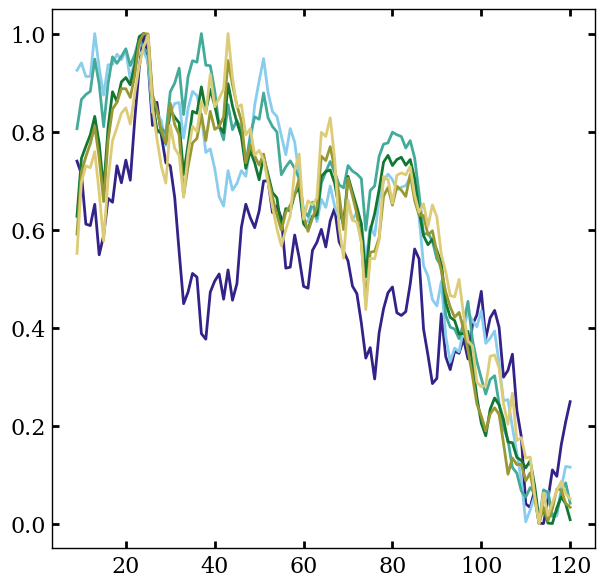

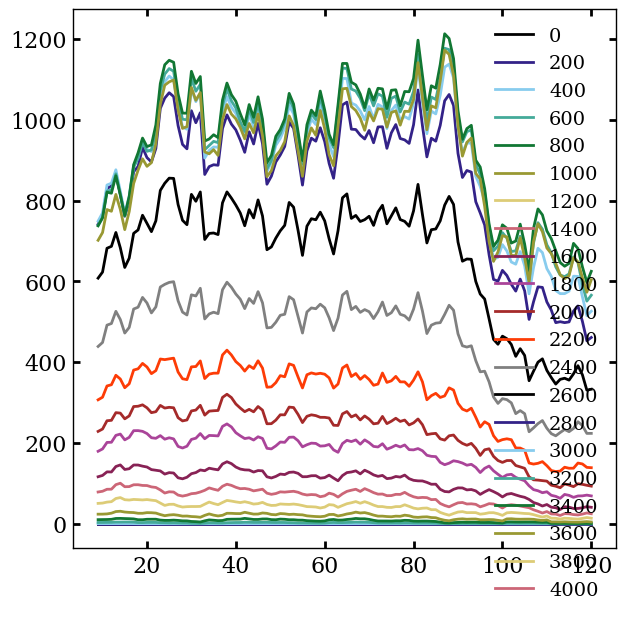

In [179]:
fig,ax = plt.subplots()
ax.plot(rolling_snow, label = elevation_bands[:-1])
ax.legend()
plt.show()

In [181]:
test = pd.DataFrame(ts_snow.values).rolling(window = 3).mean()

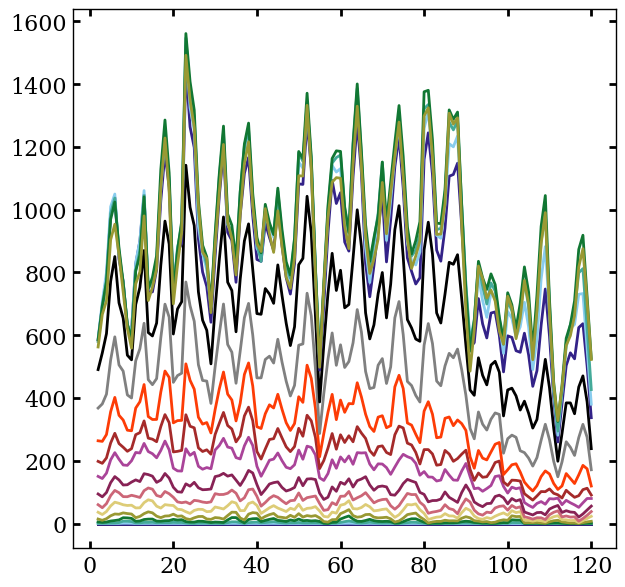

In [172]:
fig,ax = plt.subplots()
ax.plot(test)
plt.show()

In [14]:
alldata_to_save = {}
for var in params['vars']: 
    alldata_to_save[var] = {}
    for state in params['states']:
        alldata_to_save[var][state] = {}
        for res in params['res']:
            alldata_to_save[var][state][res] = {}
            alldata_to_save[var][state][res]['annual_max_clipped'] = alldata[var][state][res]['annual_max_state']

In [12]:
alldata_to_save['prec']

{'CA': {}, 'WY': {}}

In [27]:
april1snow = {}
for state in params['states']:
    april1snow[state] = {}
    for res in params['res']:
        domain = state_res_domain[state][res]
        rawdata = alldata[var][state][res]['raw']
        left, right, bottom, top = boundaries[domain][state]
        april1 = rawdata.sel(time = ( (rawdata.time.dt.month == 4) & (rawdata.time.dt.day == 1) )  )
        april1snow[state][res] = april1.sel(lat2d = slice(bottom, top), lon2d = slice(left, right))

In [15]:
alldata_to_save = {}
for var in params['vars']: 
    alldata_to_save[var] = {}
    for state in params['states']:
        alldata_to_save[var][state] = {}
        for res in params['res']:
            alldata_to_save[var][state][res] = {}
            alldata_to_save[var][state][res]['annual_max_clipped'] = alldata[var][state][res]['annual_max_state']
np.save('/glade/campaign/uwyo/wyom0112/berkeley/annual_max_clipped.npy',alldata_to_save)

In [10]:
coords_clipped = {}
for state in params['states']:
    coords_clipped[state] = {}
    for res in params['res']:
        domain = state_res_domain[state][res]
        left, right, bottom, top = boundaries[domain][state]
        basecoords = coordsdict[state_res_domain[state][res]]
        coords_clipped[state][res] =  basecoords.sel(south_north = slice(bottom, top),
                                                               west_east = slice(left, right))

In [50]:
snowmasks = {}
for state in params['states']:
    snowmasks[state] = {}
    for res in params['res']:
        snowdata = alldata['snow'][state][res]['annual_max_state']['snow']
        mask = np.nansum(snowdata[0:20], axis = 0) > 400
        snowmasks[state][res] = mask

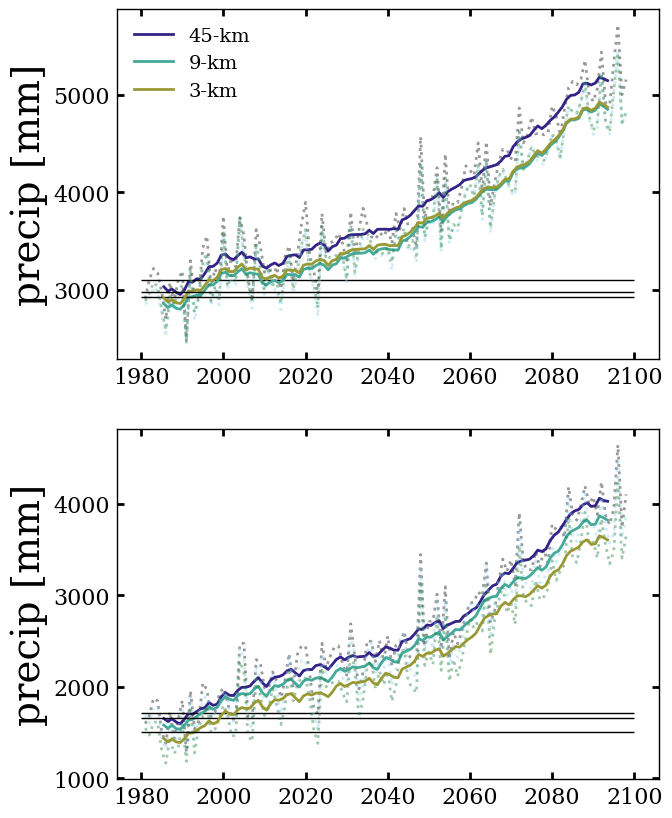

In [138]:
ws = 10
var = 't2'
fig,axs = plt.subplots(2,1, figsize = (7,10))
for i,state in enumerate(params['states']):
    ax = axs[i]
    for res in params['res']:
        domain = state_res_domain[state][res]
        mask = snowmasks[state][res]
        tmp = alldata[var][state][res]['annual_max_state']
        tmp = tmp - (273*365)
        data = np.nanmean(tmp.where(mask)[var], axis = (1,2))[1:-2]
        years = alldata[var][state][res]['annual_max_state'].time.dt.year[1:-2]
        ax.plot(years, data, linestyle = ':', alpha = 0.4)
        rolling_yearmean = pd.DataFrame(years).rolling(window = ws).mean()
        rolling_mean = pd.DataFrame(data).rolling(window=ws).mean()
        ax.plot(rolling_yearmean,rolling_mean, label = f'{res}-km')
        ax.hlines(np.nanmean(data[0:20]), 1980, 2100, linewidth = 1)

    ax.set_ylabel('precip [mm]')
    #ax.set_ylim((-30, 180))
axs[0].legend(loc = 'upper left')
#axs[0].text(1980, 140, 'CA')
#axs[1].text(1980, 200, 'WY')
plt.show()

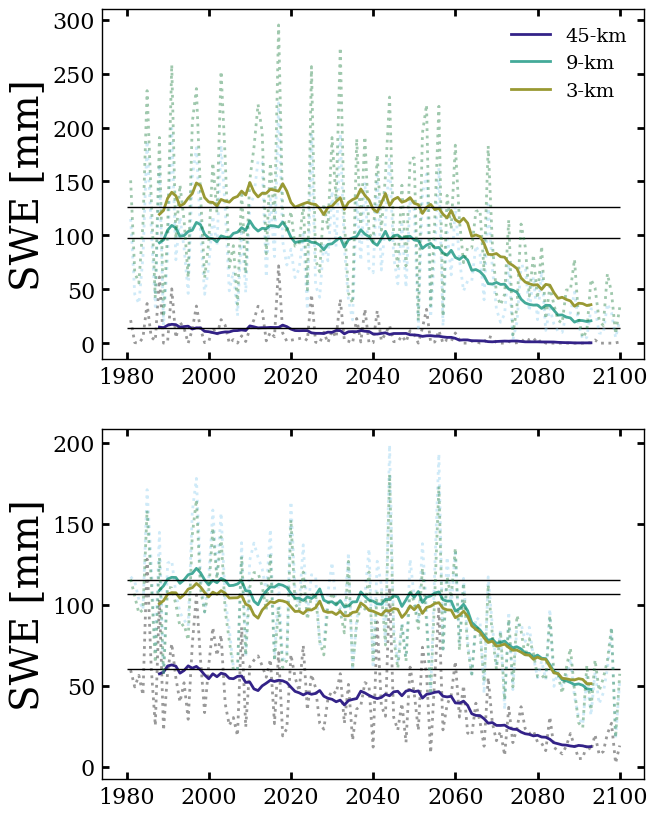

In [54]:
ws = 15
var = 'snow'
fig,axs = plt.subplots(2,1, figsize = (7,10))
for i,state in enumerate(params['states']):
    ax = axs[i]
    for res in params['res']:
        domain = state_res_domain[state][res]
        mask = snowmasks[state][res]
        april1data = april1snow[state][res]
        data = np.nanmean(april1data.where(mask)[var], axis = (1,2))
        years = april1data.time.dt.year
        ax.plot(years, data, linestyle = ':', alpha = 0.4)
        rolling_yearmean = pd.DataFrame(years).rolling(window = ws).mean()
        rolling_mean = pd.DataFrame(data).rolling(window=ws).mean()
        ax.plot(rolling_yearmean,rolling_mean, label = f'{res}-km')
        ax.hlines(np.nanmean(data[0:20]), 1980, 2100, linewidth = 1)

    ax.set_ylabel('SWE [mm]')
    #ax.set_ylim((-30, 180))
axs[0].legend(loc = 'upper right')
#axs[0].text(1980, 140, 'CA')
#axs[1].text(1980, 200, 'WY')
plt.show()

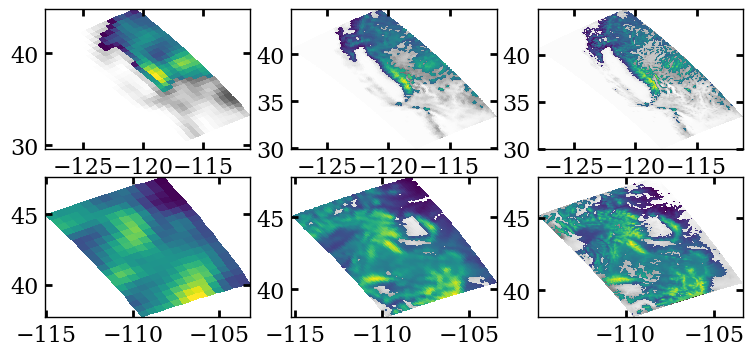

In [51]:
## visualize some of the masks
fig,axs = plt.subplots(2,3, figsize = (9,4))
for i,state in enumerate(params['states']):
    for j,res in enumerate(params['res']):
        ax = axs[i,j]
        coords = coords_clipped[state][res]
        mask = snowmasks[state][res] 
        tlat = coords['XLAT'][0]
        tlon = coords['XLONG'][0]
        z = coords['HGT'][0]
        ax.pcolormesh(tlon, tlat, z, cmap = 'Greys')
        ax.pcolormesh(tlon, tlat, z.where(mask), cmap = 'viridis')
plt.show()

In [9]:
state = 'CA'
res = '3'
snow = np.nanmean(alldata['snow'][state][res]['annual_max_state'].where(snowmasks[state][res])['snow'], axis = (1,2))
precip = np.nanmean(alldata['prec'][state][res]['annual_max_state'].where(snowmasks[state][res])['prec'], axis = (1,2))
temp = np.nanmean(alldata['t2'][state][res]['annual_max_state'].where(snowmasks[state][res])['t2'], axis = (1,2))
                                                                                     

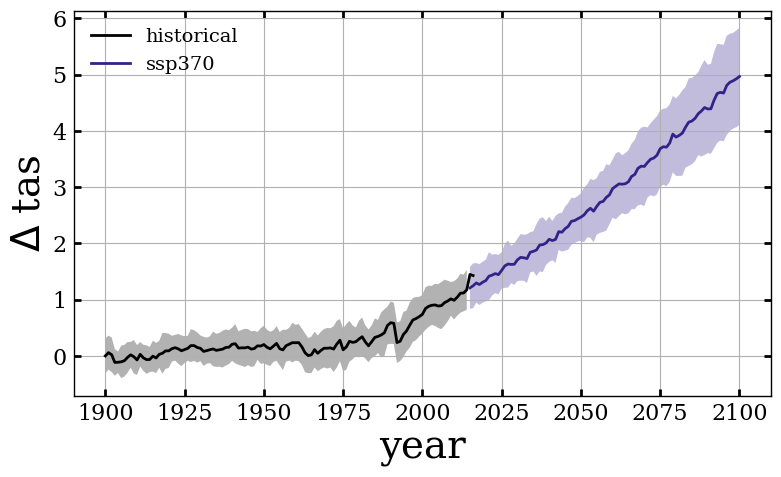

In [10]:
tas_ts = pd.read_csv('wrfrun_globalavg_temp.csv', index_col = 0, parse_dates = True)
mask = (tas_ts['year'] >= 1850) & (tas_ts['year'] <= 1900)
baseline = tas_ts[mask].groupby('year').mean(numeric_only = True).mean().values[0]
tas_ts['d_tas'] = tas_ts['tas'] - baseline

fig, ax = plt.subplots(figsize=(9,5))
    
for experiment_id, data in tas_ts.groupby('experiment_id'):
    grouped = data.groupby('year')['d_tas'].agg(['mean', 'std'])
    ax.plot(grouped.index, grouped['mean'], label=f"{experiment_id}")
    ax.fill_between(grouped.index, grouped['mean'] - grouped['std'], grouped['mean'] + grouped['std'], alpha=0.3)
ax.set_xlabel("year")
ax.set_ylabel(r"$\Delta$ tas")
ax.legend(frameon = False, loc = 'upper left')
ax.grid(True)

plt.show()


In [11]:
gcms_long = ['cesm2_r11i1p1f1_ssp370', 'mpi-esm1-2-lr_r7i1p1f1_ssp370',
       'cnrm-esm2-1_r1i1p1f2_ssp370', 'ec-earth3-veg_r1i1p1f1_ssp370',
       'fgoals-g3_r1i1p1f1_ssp370', 'ukesm1-0-ll_r2i1p1f2_ssp370',
       'canesm5_r1i1p2f1_ssp370', 'access-cm2_r5i1p1f1_ssp370',
       'ec-earth3_r1i1p1f1_ssp370']

map_gcm = {}
for i,rawname in enumerate(tas_ts.source_id.unique()):
    map_gcm[rawname] = {}
    map_gcm[gcms[i]] = {}
    map_gcm[rawname]['raw_to_short'] = gcms[i]
    map_gcm[gcms[i]]['short_to_raw'] = rawname
    map_gcm[gcms[i]]['short_to_long'] = gcms_long[i]
    

NameError: name 'gcms' is not defined

In [ ]:
diff_from_baseline = []
per_deg_cc = []

tas_gcm = tas_ts[tas_ts.source_id == map_gcm[gcm]['short_to_raw']]
tmp  = tas_gcm.groupby('year').mean(numeric_only = True)['d_tas']
df = pd.DataFrame(tmp)
tas_xr = xr.Dataset(data_vars={'d_tas': ('time', df['d_tas'].values)},
                coords={'time': df.index.values}).sel(time = slice(1981,2100))

for i,state in enumerate(params['states']):
    for j,res in enumerate(params['res']):
        snowmax = alldata['snow'][state][res]['annual_max_state']
        baseline = snowmax.sel(time = slice(1981, 2000)).mean(dim = 'time')
        diff = snow_gcm['snow'] - baseline['snow']
        diff_from_baseline.append(diff)
        per_deg_cc.append(diff / tas_xr['d_tas'])

In [104]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

state = 'CA'
res = '3'

def make_stackplot_var(state, res):
    snow = np.nanmean(alldata['snow'][state][res]['annual_max_state'].where(snowmasks[state][res])['snow'], axis = (1,2))
    precip = np.nanmean(alldata['prec'][state][res]['annual_max_state'].where(snowmasks[state][res])['prec'], axis = (1,2))
    temp = np.nanmean(alldata['t2'][state][res]['annual_max_state'].where(snowmasks[state][res])['t2'], axis = (1,2))

    # Combine the three DataFrames into one
    combined_data = pd.concat([pd.Series(snow), pd.Series(precip), pd.Series(temp)], axis=1)
    combined_data['year'] = range(1980, 2101)
    combined_data.columns = ['snow', 'precipitation', 'temperature', 'year']
    # Create a list to store the R-squared values for each decade


    # Define the start and end years for each decade
    decades = [(1980, 1989), (1990, 1999), (2000, 2009), (2010, 2019), (2020, 2029), (2030, 2039), (2040, 2049), (2050, 2059), (2060, 2069), (2070, 2079), (2080, 2089), (2090, 2099)]

    r2 = {}
    for var in ['precipitation', 'temperature']:
        r2[var]  = [] #r_squared_values = []
        for start_year, end_year in decades:


                # Filter data for the current decade
                decade_data = combined_data[(combined_data['year'] >= start_year) & (combined_data['year'] <= end_year)]

                # Perform linear regression
                X = np.array(decade_data[var]).reshape((1,-1))
                y = np.array(decade_data['snow']).reshape((1,-1))

                slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

                # Calculate R-squared value
                r_squared = r_value**2

                # Append the R-squared value to the list
                r2[var] .append(r_squared)


    a = r2['precipitation']
    b = r2['temperature'] 
    neither = [1 - (ai + bi) for ai, bi in zip(a, b)]


    # Create the stack plot
    plt.figure(figsize=(8, 6))
    plt.stackplot(range(1980,2100,10), a, b, neither, labels=['precipitation', 'temperature', 'Neither'])
    plt.legend(loc='upper left')
    plt.xlabel('Decade')
    plt.ylabel('Proportion')
    plt.show()
    return


/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


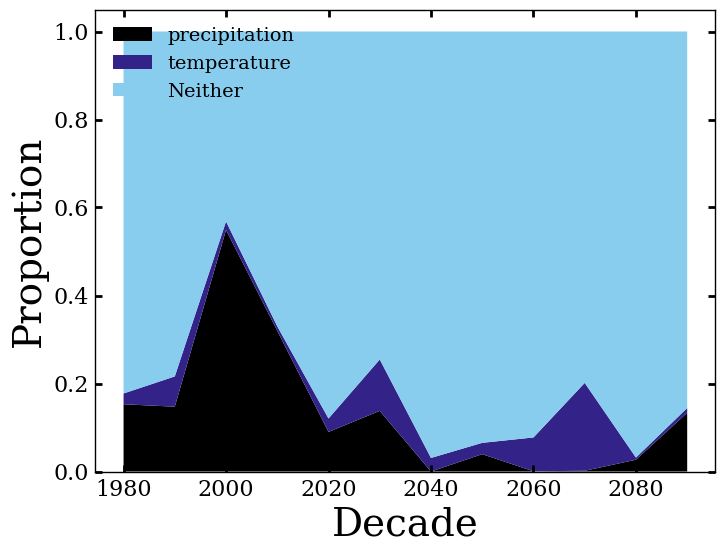

/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


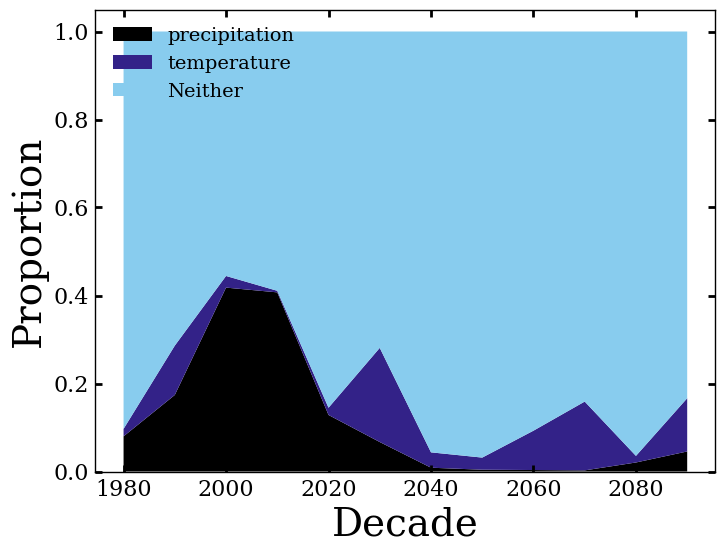

/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


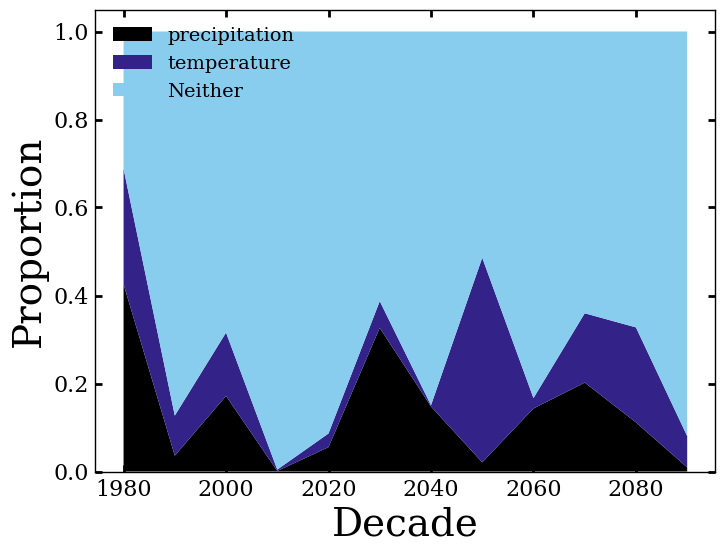

In [106]:
make_stackplot_var('CA', '3')
make_stackplot_var('CA', '9')
make_stackplot_var('WY', '3')